## PyTorch/TPU MNIST Demo

This colab example corresponds to the implementation under [test_train_mp_mnist.py](https://github.com/pytorch/xla/blob/master/test/test_train_mp_mnist.py).

<h3>  &nbsp;&nbsp;Use Colab Cloud TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

* On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
* The cell below makes sure you have access to a TPU on Colab.


In [2]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

### [RUNME] Install Colab TPU compatible PyTorch/TPU wheels and dependencies

In [1]:
!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━

### Define Parameters and Helpers, and start Training


In [1]:
# Result Visualization Helper
import math
from matplotlib import pyplot as plt

M, N = 4, 6
RESULT_IMG_PATH = '/tmp/test_result.png'

def plot_results(images, labels, preds):
  images, labels, preds = images[:M*N], labels[:M*N], preds[:M*N]
  inv_norm = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))

  num_images = images.shape[0]
  fig, axes = plt.subplots(M, N, figsize=(11, 9))
  fig.suptitle('Correct / Predicted Labels (Red text for incorrect ones)')

  for i, ax in enumerate(fig.axes):
    ax.axis('off')
    if i >= num_images:
      continue
    img, label, prediction = images[i], labels[i], preds[i]
    img = inv_norm(img)
    img = img.squeeze() # [1,Y,X] -> [Y,X]
    label, prediction = label.item(), prediction.item()
    if label == prediction:
      ax.set_title(u'\u2713', color='blue', fontsize=22)
    else:
      ax.set_title(
          'X {}/{}'.format(label, prediction), color='red')
    ax.imshow(img)
  plt.savefig(RESULT_IMG_PATH, transparent=True)

In [2]:
# Define Parameters
FLAGS = {}
FLAGS['datadir'] = "/tmp/mnist"
FLAGS['batch_size'] = 128
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 0.01
FLAGS['momentum'] = 0.5
FLAGS['num_epochs'] = 10
FLAGS['num_cores'] = 8
FLAGS['log_steps'] = 20
FLAGS['metrics_debug'] = False

In [3]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
from torchvision import datasets, transforms


SERIAL_EXEC = xmp.MpSerialExecutor()

class MNIST(nn.Module):

  def __init__(self):
    super(MNIST, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.bn1 = nn.BatchNorm2d(10)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.bn2 = nn.BatchNorm2d(20)
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = self.bn1(x)
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = self.bn2(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

# Only instantiate model weights once in memory.
WRAPPED_MODEL = xmp.MpModelWrapper(MNIST())

def train_mnist():
  torch.manual_seed(1)

  def get_dataset():
    norm = transforms.Normalize((0.1307,), (0.3081,))
    train_dataset = datasets.MNIST(
        FLAGS['datadir'],
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), norm]))
    test_dataset = datasets.MNIST(
        FLAGS['datadir'],
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), norm]))

    return train_dataset, test_dataset

  # Using the serial executor avoids multiple processes to
  # download the same data.
  train_dataset, test_dataset = SERIAL_EXEC.run(get_dataset)

  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)
  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=FLAGS['batch_size'],
      shuffle=False,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

  # Scale learning rate to world size
  lr = FLAGS['learning_rate'] * xm.xrt_world_size()

  # Get loss function, optimizer, and model
  device = xm.xla_device()
  model = WRAPPED_MODEL.to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=FLAGS['momentum'])
  loss_fn = nn.NLLLoss()

  def train_loop_fn(loader):
    tracker = xm.RateTracker()
    model.train()
    for x, (data, target) in enumerate(loader):
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      loss.backward()
      xm.optimizer_step(optimizer)
      tracker.add(FLAGS['batch_size'])
      if x % FLAGS['log_steps'] == 0:
        print('[xla:{}]({}) Loss={:.5f} Rate={:.2f} GlobalRate={:.2f} Time={}'.format(
            xm.get_ordinal(), x, loss.item(), tracker.rate(),
            tracker.global_rate(), time.asctime()), flush=True)

  def test_loop_fn(loader):
    total_samples = 0
    correct = 0
    model.eval()
    data, pred, target = None, None, None
    for data, target in loader:
      output = model(data)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
      total_samples += data.size()[0]

    accuracy = 100.0 * correct / total_samples
    print('[xla:{}] Accuracy={:.2f}%'.format(
        xm.get_ordinal(), accuracy), flush=True)
    return accuracy, data, pred, target

  # Train and eval loops
  accuracy = 0.0
  data, pred, target = None, None, None
  for epoch in range(1, FLAGS['num_epochs'] + 1):
    para_loader = pl.ParallelLoader(train_loader, [device])
    train_loop_fn(para_loader.per_device_loader(device))
    xm.master_print("Finished training epoch {}".format(epoch))

    para_loader = pl.ParallelLoader(test_loader, [device])
    accuracy, data, pred, target  = test_loop_fn(para_loader.per_device_loader(device))
    if FLAGS['metrics_debug']:
      xm.master_print(met.metrics_report(), flush=True)

  return accuracy, data, pred, target

In [4]:
# Start training processes
def _mp_fn(rank, flags):
  global FLAGS
  FLAGS = flags
  torch.set_default_tensor_type('torch.FloatTensor')
  accuracy, data, pred, target = train_mnist()
  if rank == 0:
    # Retrieve tensors that are on TPU core 0 and plot.
    plot_results(data.cpu(), pred.cpu(), target.cpu())

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
          start_method='fork')

100%|██████████| 9912422/9912422 [00:00<00:00, 91843490.42it/s]


Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111235715.17it/s]


Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21802523.90it/s]


Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19146260.07it/s]


Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw

[xla:2](0) Loss=2.29280 Rate=228.66 GlobalRate=228.65 Time=Thu Jun 15 16:22:34 2023[xla:0](0) Loss=2.30130 Rate=138.01 GlobalRate=138.01 Time=Thu Jun 15 16:22:34 2023

[xla:7](0) Loss=2.26931 Rate=296.78 GlobalRate=296.77 Time=Thu Jun 15 16:22:34 2023
[xla:1](0) Loss=2.31269 Rate=456.76 GlobalRate=456.74 Time=Thu Jun 15 16:22:34 2023
[xla:6](0) Loss=2.32783 Rate=452.21 GlobalRate=452.20 Time=Thu Jun 15 16:22:34 2023
[xla:4](0) Loss=2.29142 Rate=526.28 GlobalRate=526.26 Time=Thu Jun 15 16:22:35 2023
[xla:3](0) Loss=2.30902 Rate=527.20 GlobalRate=527.18 Time=Thu Jun 15 16:22:35 2023
[xla:5](0) Loss=2.28664 Rate=430.89 GlobalRate=430.86 Time=Thu Jun 15 16:22:35 2023
[xla:3](20) Loss=0.35357 Rate=855.13 GlobalRate=1023.23 Time=Thu Jun 15 16:22:37 2023
[xla:5](20) Loss=0.38562 Rate=892.15 GlobalRate=1105.71 Time=Thu Jun 15 16:22:37 2023[xla:2](20) Loss=0.38587 Rate=546.46 GlobalRate=682.99 Time=Thu Jun 15 16:

## Visualize Predictions

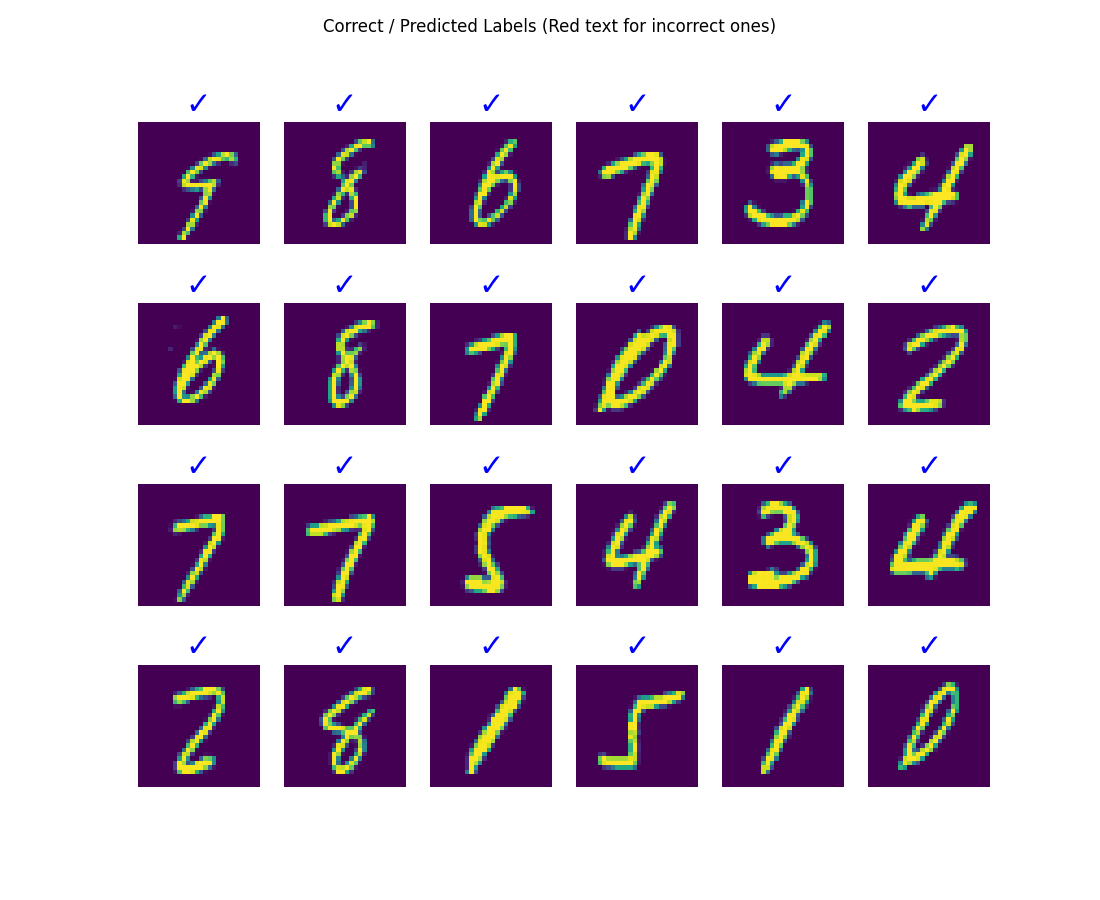

In [5]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)